# Human in the Loop

There are many occasions where you would like to put a human in the loop to keep tabs on what an agent is doing
.


# Setup

In [1]:
from dotenv import load_dotenv

In [2]:
_ = load_dotenv()

# Global Imports

In [3]:
import operator
from typing import Annotated, TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from rich import print as rprint

In [4]:
memory = SqliteSaver.from_conn_string(":memory:")

> **We're gonna perform a small modification**.

In the previous examples, we annotated the messages list with the `operator.add`. That added messages to the existing messages array. 

However, for this human-in-the-loop interactions, **we may want to actually replace these existing messages**.

In order to do that, we're going to write a custom `reduce_messages` function, that basically looks for messages with the same id, and appends them otherwise.

In [5]:
from uuid import uuid4

from langchain_core.messages import AIMessage

In [6]:
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # Assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # Merge the new messages (from the right) to the existing ones (from the left)
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # Replace any existing message (from the left)
            # By one with the same id (from the right)
            if existing.id == message.id:
                merged[i] = message
                break
        # This `else` clause suggests no `break` was encountered, it's not mandatory
        else:
            # Append any new message to the end
            merged.append(message)
    return merged

In [7]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [8]:
tool = TavilySearchResults(max_results=2)

# Manual Human Approval

We'll implement the same Agent, but **with one small crucial modification**.

In `graph.compile`, we will set a new parameter `interrupt_before=["action"]` to **allow manual approval before running actions**.

In [9]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]  # 👈 Allow manual human approval before running tools
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

> **NOTE**
>
> Sometimes, you may want to interrupt only before a certain tool is called. This is covered in other parts of the documentation. **FIND LINK TO THIS!**

Let's initialize the Agent exactly like before.

In [10]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [11]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in SF?', id='76f7b8e1-77c3-4fcf-b6e0-8a34d6ebd8b3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-05dec0e6-9b34-4b1e-a0df-37b403b390c6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 't

We stream back responses and we stop after this `AIMessage`.

This is because it is saying that we should call a tool, but we have that `interrupt_before` parameter which stops it there.

One thing we can do from here, is get the current state of the graph for this thread, like it's done below:

In [13]:
rprint(abot.graph.get_state(thread))

StateSnapshot(
    values={
        'messages': [
            HumanMessage(content='Whats the weather in SF?', id='76f7b8e1-77c3-4fcf-b6e0-8a34d6ebd8b3'),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t',
                            'function': {
                                'arguments': '{"query":"weather in San Francisco"}',
                                'name': 'tavily_search_results_json'
                            },
                            'type': 'function'
                        }
                    ]
                },
                response_metadata={
                    'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173},
                    'model_name': 'gpt-3.5-turbo',
                    'system_fingerprint': None,
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                id='run-05dec0e6-9b34-4b1e-a0df-37b403b390c6-0',
                tool_calls=[
                    {
                        'name': 'tavily_search_results_json',
                        'args': {'query': 'weather in San Francisco'},
                        'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t'
                    }
                ],
                usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173}
            )
        ]
    },
    next=('action',),
    config={'configurable': {'thread_id': '1', 'thread_ts': '1ef28b52-8b28-6657-8001-cc53dd04773a'}},
    metadata={
        'source': 'loop',
        'step': 1,
        'writes': {
            'llm': {
                'messages': [
                    AIMessage(
                        content='',
                        additional_kwargs={
                            'tool_calls': [
                                {
                                    'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t',
                                    'function': {
                                        'arguments': '{"query":"weather in San Francisco"}',
                                        'name': 'tavily_search_results_json'
                                    },
                                    'type': 'function'
                                }
                            ]
                        },
                        response_metadata={
                            'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173},
                            'model_name': 'gpt-3.5-turbo',
                            'system_fingerprint': None,
                            'finish_reason': 'tool_calls',
                            'logprobs': None
                        },
                        id='run-05dec0e6-9b34-4b1e-a0df-37b403b390c6-0',
                        tool_calls=[
                            {
                                'name': 'tavily_search_results_json',
                                'args': {'query': 'weather in San Francisco'},
                                'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t'
                            }
                        ],
                        usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173}
                    )
                ]
            }
        }
    },
    created_at='2024-06-12T12:13:20.875421+00:00',
    parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef28b52-7fe7-63ac-8000-8478707d898c'}}
)

We get back this `StateSnapshot` configuration object which has a few parameters.

One interesting to mention is the `next` one.

In [13]:
abot.graph.get_state(thread).next

('action',)

Of course, this refers to **the node that will be called next**.

## Introspection on `StateSnapshot` objects

In [14]:
snapshot = abot.graph.get_state(thread)

In [15]:
type(snapshot)

langgraph.pregel.types.StateSnapshot

In [18]:
snapshot_attrs = [elem for elem in dir(snapshot) if elem[0] != "_"]
snapshot_attrs

['config',
 'count',
 'created_at',
 'index',
 'metadata',
 'next',
 'parent_config',
 'values']

In [19]:
snapshot.config

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef28b52-8b28-6657-8001-cc53dd04773a'}}

In [22]:
snapshot.count?

Signature: snapshot.count(value, /)
Docstring: Return number of occurrences of value.
Type:      builtin_function_or_method

In [23]:
snapshot.created_at

'2024-06-12T12:13:20.875421+00:00'

In [26]:
snapshot.index?

Signature: snapshot.index(value, start=0, stop=9223372036854775807, /)
Docstring:
Return first index of value.

Raises ValueError if the value is not present.
Type:      builtin_function_or_method

In [27]:
snapshot.metadata

{'source': 'loop',
 'step': 1,
 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-05dec0e6-9b34-4b1e-a0df-37b403b390c6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}}}

In [35]:
snapshot.next

('action',)

In [36]:
snapshot.parent_config

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef28b52-7fe7-63ac-8000-8478707d898c'}}

In [40]:
snapshot.values

{'messages': [HumanMessage(content='Whats the weather in SF?', id='76f7b8e1-77c3-4fcf-b6e0-8a34d6ebd8b3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-05dec0e6-9b34-4b1e-a0df-37b403b390c6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_YYrkV2SdSWuyWLdb6vX0J42t'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}

In [41]:
type(snapshot.values)

dict

In [42]:
snapshot.values.keys()

dict_keys(['messages'])

In [43]:
snapshot.values?

Type:        dict
String form: {'messages': [HumanMessage(content='Whats the weather in SF?', id='76f7b8e1-77c3-4fcf-b6e0-8a34d6 <...> Ldb6vX0J42t'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}
Length:      1
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

In [44]:
type(snapshot)

langgraph.pregel.types.StateSnapshot

# Continue After Interrupt

In order to continue, we can call stream again, with the same `thread` config, and just pass in `None`, instead of the dictionary with messages.

In [14]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        rprint(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_4LWUMpNe4mKVgxtUlssLwyA5'}
Back to the model!


{
    'messages': [
        ToolMessage(
            content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San 
Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': 
-122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1718191133, \'localtime\': \'2024-06-12 4:18\'}, 
\'current\': {\'last_updated_epoch\': 1718190900, \'last_updated\': \'2024-06-12 04:15\', \'temp_c\': 13.3, 
\'temp_f\': 55.9, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': 
\'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, 
\'wind_degree\': 10, \'wind_dir\': \'N\', \'pressure_mb\': 1010.0, \'pressure_in\': 29.83, \'precip_mm\': 0.0, 
\'precip_in\': 0.0, \'humidity\': 88, \'cloud\': 0, \'feelslike_c\': 12.5, \'feelslike_f\': 54.4, \'windchill_c\': 
10.9, \'windchill_f\': 51.6, \'heatindex_c\': 12.0, \'heatindex_f\': 53.6, \'dewpoint_c\': 10.1, \'dewpoint_f\': 
50.1, \'vis_km\': 16.0, \'vis_miles\': 9.0, \'uv\': 1.0, \'gust_mph\': 10.8, \'gust_kph\': 17.3}}"}, {\'url\': 
\'https://weather.com/weather/monthly/l/San+Francisco+CA+94132:4:US\', \'content\': \'A few passing clouds, 
otherwise generally clear. Low 51F. Winds SW at 10 to 20 mph. Record Low37°. Average Low52°. Moonrise5:33 am. New 
Moon. Moonset9:20 pm.\'}]',
            name='tavily_search_results_json',
            tool_call_id='call_4LWUMpNe4mKVgxtUlssLwyA5'
        )
    ]
}

{'messages': [HumanMessage(content='Whats the weather in SF?', id='9971096b-2b3b-4f0b-bee4-e51e6b4a9164'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4LWUMpNe4mKVgxtUlssLwyA5', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b6a1984a-8e4f-415b-88fc-886c14a08f93-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_4LWUMpNe4mKVgxtUlssLwyA5'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173}), ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of Ame

{
    'messages': [
        AIMessage(
            content='The current weather in San Francisco is clear with a temperature of 55.9°F (13.3°C). The wind 
is coming from the north at 2.2 mph (3.6 kph). The humidity is at 88%, and there is no precipitation.',
            response_metadata={
                'token_usage': {'completion_tokens': 57, 'prompt_tokens': 675, 'total_tokens': 732},
                'model_name': 'gpt-3.5-turbo',
                'system_fingerprint': None,
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-545b8b19-4e15-4f5f-8041-3b484fff3804-0',
            usage_metadata={'input_tokens': 675, 'output_tokens': 57, 'total_tokens': 732}
        )
    ]
}

We now get the full state of messages.

In [15]:
rprint(abot.graph.get_state(thread))

StateSnapshot(
    values={
        'messages': [
            HumanMessage(content='Whats the weather in SF?', id='9971096b-2b3b-4f0b-bee4-e51e6b4a9164'),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_4LWUMpNe4mKVgxtUlssLwyA5',
                            'function': {
                                'arguments': '{"query":"weather in San Francisco"}',
                                'name': 'tavily_search_results_json'
                            },
                            'type': 'function'
                        }
                    ]
                },
                response_metadata={
                    'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173},
                    'model_name': 'gpt-3.5-turbo',
                    'system_fingerprint': None,
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                id='run-b6a1984a-8e4f-415b-88fc-886c14a08f93-0',
                tool_calls=[
                    {
                        'name': 'tavily_search_results_json',
                        'args': {'query': 'weather in San Francisco'},
                        'id': 'call_4LWUMpNe4mKVgxtUlssLwyA5'
                    }
                ],
                usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173}
            ),
            ToolMessage(
                content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San 
Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': 
-122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1718191133, \'localtime\': \'2024-06-12 4:18\'}, 
\'current\': {\'last_updated_epoch\': 1718190900, \'last_updated\': \'2024-06-12 04:15\', \'temp_c\': 13.3, 
\'temp_f\': 55.9, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': 
\'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, 
\'wind_degree\': 10, \'wind_dir\': \'N\', \'pressure_mb\': 1010.0, \'pressure_in\': 29.83, \'precip_mm\': 0.0, 
\'precip_in\': 0.0, \'humidity\': 88, \'cloud\': 0, \'feelslike_c\': 12.5, \'feelslike_f\': 54.4, \'windchill_c\': 
10.9, \'windchill_f\': 51.6, \'heatindex_c\': 12.0, \'heatindex_f\': 53.6, \'dewpoint_c\': 10.1, \'dewpoint_f\': 
50.1, \'vis_km\': 16.0, \'vis_miles\': 9.0, \'uv\': 1.0, \'gust_mph\': 10.8, \'gust_kph\': 17.3}}"}, {\'url\': 
\'https://weather.com/weather/monthly/l/San+Francisco+CA+94132:4:US\', \'content\': \'A few passing clouds, 
otherwise generally clear. Low 51F. Winds SW at 10 to 20 mph. Record Low37°. Average Low52°. Moonrise5:33 am. New 
Moon. Moonset9:20 pm.\'}]',
                name='tavily_search_results_json',
                id='c78baf84-8a4f-4803-851b-4ffd6192a913',
                tool_call_id='call_4LWUMpNe4mKVgxtUlssLwyA5'
            ),
            AIMessage(
                content='The current weather in San Francisco is clear with a temperature of 55.9°F (13.3°C). The 
wind is coming from the north at 2.2 mph (3.6 kph). The humidity is at 88%, and there is no precipitation.',
                response_metadata={
                    'token_usage': {'completion_tokens': 57, 'prompt_tokens': 675, 'total_tokens': 732},
                    'model_name': 'gpt-3.5-turbo',
                    'system_fingerprint': None,
                    'finish_reason': 'stop',
                    'logprobs': None
                },
                id='run-545b8b19-4e15-4f5f-8041-3b484fff3804-0',
                usage_metadata={'input_tokens': 675, 'output_tokens': 57, 'total_tokens': 732}
            )
        ]
    },
    next=(),
    config={'configurable': {'thread_id': '1', 'thread_ts': '1ef28ae0-ae75-6acc-8003-22bd15eff90a'}},
    metadata={
        'so

In [16]:
abot.graph.get_state(thread).next

()

There's nothing left to be done.

We can indeed build some code that runs it in a little loop.

In [17]:
messages = [HumanMessage("What's the Weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}

for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        rprint(v)

while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread), "\n")
    _input = input("proceed?")
    if _input != "y":
        print("ABORTING")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            rprint(v)

{'messages': [HumanMessage(content="What's the Weather in LA?", id='3cbea027-2112-4bdb-be87-4875d5c91656'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Tp2MNCG1ayPpskVsHsHbUUzX', 'function': {'arguments': '{"query":"Weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-81f53c92-22b3-4c02-8d06-cbf8cff9d813-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Weather in Los Angeles'}, 'id': 'call_Tp2MNCG1ayPpskVsHsHbUUzX'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174})]}


{
    'messages': [
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'call_Tp2MNCG1ayPpskVsHsHbUUzX',
                        'function': {
                            'arguments': '{"query":"Weather in Los Angeles"}',
                            'name': 'tavily_search_results_json'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                'model_name': 'gpt-3.5-turbo',
                'system_fingerprint': None,
                'finish_reason': 'tool_calls',
                'logprobs': None
            },
            id='run-81f53c92-22b3-4c02-8d06-cbf8cff9d813-0',
            tool_calls=[
                {
                    'name': 'tavily_search_results_json',
                    'args': {'query': 'Weather in Los Angeles'},
                    'id': 'call_Tp2MNCG1ayPpskVsHsHbUUzX'
                }
            ],
            usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
        )
    ]
}


 StateSnapshot(values={'messages': [HumanMessage(content="What's the Weather in LA?", id='3cbea027-2112-4bdb-be87-4875d5c91656'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Tp2MNCG1ayPpskVsHsHbUUzX', 'function': {'arguments': '{"query":"Weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-81f53c92-22b3-4c02-8d06-cbf8cff9d813-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Weather in Los Angeles'}, 'id': 'call_Tp2MNCG1ayPpskVsHsHbUUzX'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174})]}, next=('action',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef28ae0-bb14-6baa-8001-f67c48bf4347'}}, metadata={'source': 'loop', 'step': 1, 'writes': 

{
    'messages': [
        ToolMessage(
            content="[{'url': 
'https://weather.com/weather/today/l/Los+Angeles+CA?canonicalCityId=84c64154109916077c8d3c2352410aaae5f6eeff682000e
3a7470e38976128c2', 'content': 'Los Angeles, CA Forecast · Morning. 63°. Chance of Rain1% · Afternoon. 71°. Chance 
of Rain0% · Evening. 63°. Chance of Rain5% · Overnight. 62°. Chance of Rain7%\\xa0...'}, {'url': 
'https://www.accuweather.com/en/us/los-angeles/90012/weather-forecast/347625', 'content': 'Hourly Weather · 1 AM 
60°. rain drop 0% · 2 AM 60°. rain drop 0% · 3 AM 60°. rain drop 0% · 4 AM 59°. rain drop 0% · 5 AM 59°. rain drop 
0% · 6 AM 60°. rain\\xa0...'}]",
            name='tavily_search_results_json',
            tool_call_id='call_Tp2MNCG1ayPpskVsHsHbUUzX'
        )
    ]
}

{'messages': [HumanMessage(content="What's the Weather in LA?", id='3cbea027-2112-4bdb-be87-4875d5c91656'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Tp2MNCG1ayPpskVsHsHbUUzX', 'function': {'arguments': '{"query":"Weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-81f53c92-22b3-4c02-8d06-cbf8cff9d813-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Weather in Los Angeles'}, 'id': 'call_Tp2MNCG1ayPpskVsHsHbUUzX'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}), ToolMessage(content="[{'url': 'https://weather.com/weather/today/l/Los+Angeles+CA?canonicalCityId=84c64154109916077c8d3c2352410aaae5f6eeff682000e3a7470e38976128c2', 'content': 'Los Angeles, 

{
    'messages': [
        AIMessage(
            content='The weather in Los Angeles is as follows:\n- Morning: 63°F, 1% chance of rain\n- Afternoon: 
71°F, 0% chance of rain\n- Evening: 63°F, 5% chance of rain\n- Overnight: 62°F, 7% chance of rain\n\nYou can find 
more detailed hourly weather information on 
[AccuWeather](https://www.accuweather.com/en/us/los-angeles/90012/weather-forecast/347625).',
            response_metadata={
                'token_usage': {'completion_tokens': 105, 'prompt_tokens': 424, 'total_tokens': 529},
                'model_name': 'gpt-3.5-turbo',
                'system_fingerprint': None,
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-54a3e2d6-caf5-4fa8-8a61-bdaecd493ba0-0',
            usage_metadata={'input_tokens': 424, 'output_tokens': 105, 'total_tokens': 529}
        )
    ]
}

# State Memory

Before we go to the next section, let's talk a little bit more about **state memory**.

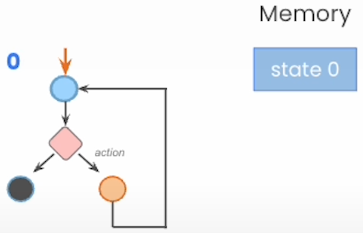

As a graph is executing, **a snapshot of each state is stored in memory**.

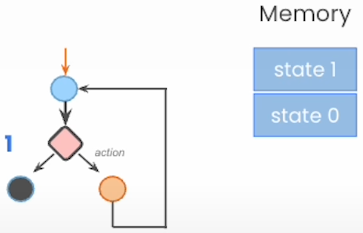 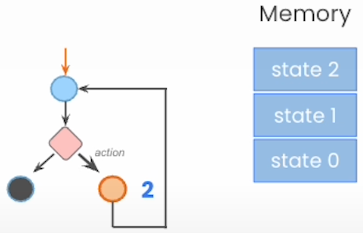

> **What's in that snapshot?**
> 
> Well, there are:
> - the agent state which has already been defined,
> - other useful things, for example there's a thread and an unique identifier for each of the snapshots.

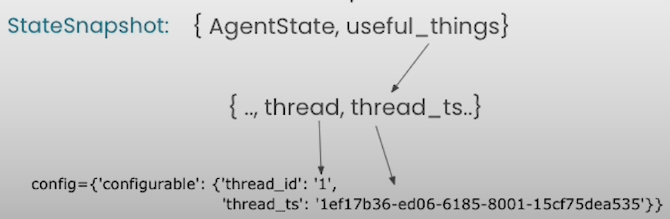

You can use that to access the snapshot

There are some commands to access memory.

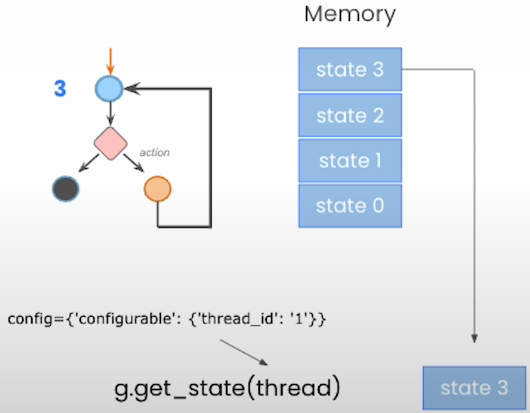

There's also `get_state_history`

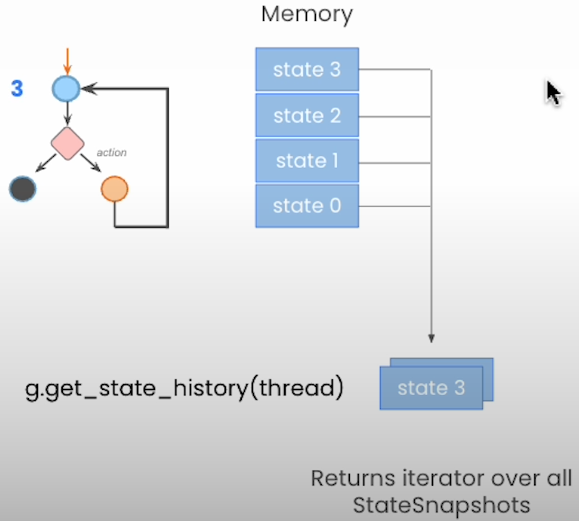

We can also perform *time travel*

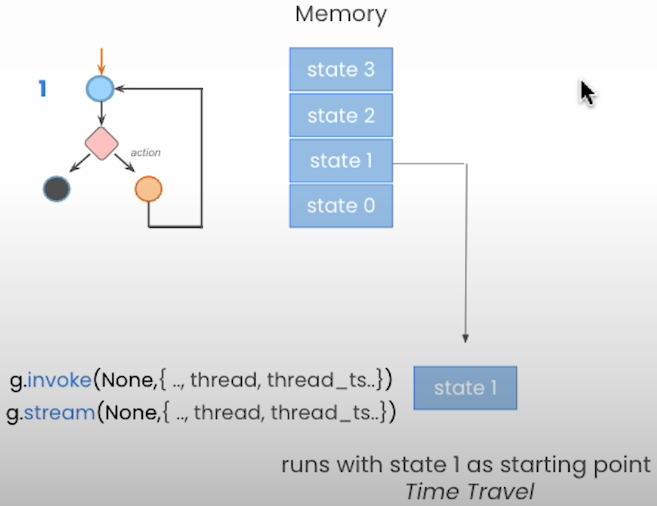

Conversely, without that `thread_ts`, if you just pass in the `thread_id`, it will use the current state of the thread as the starting point.

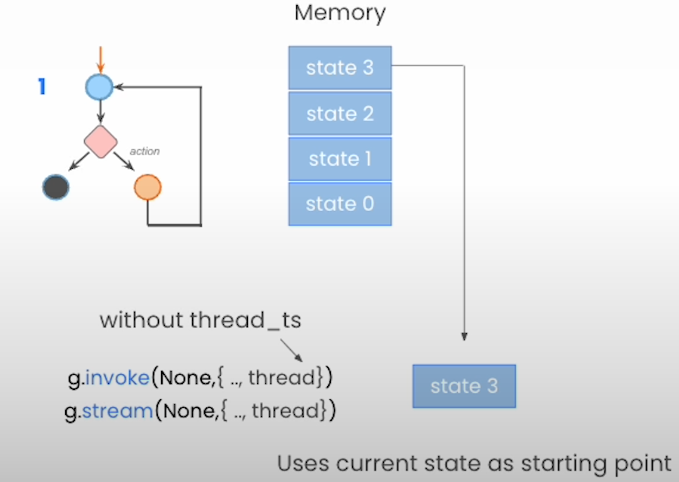

You can also use that unique identifier to **access a particular state**.

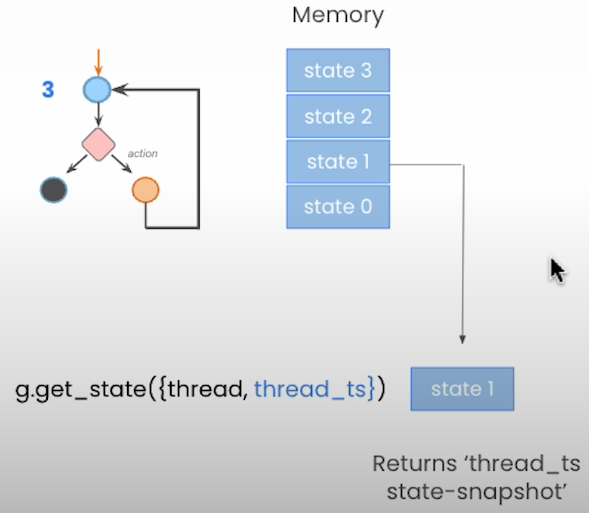

You can then **modify that state**.

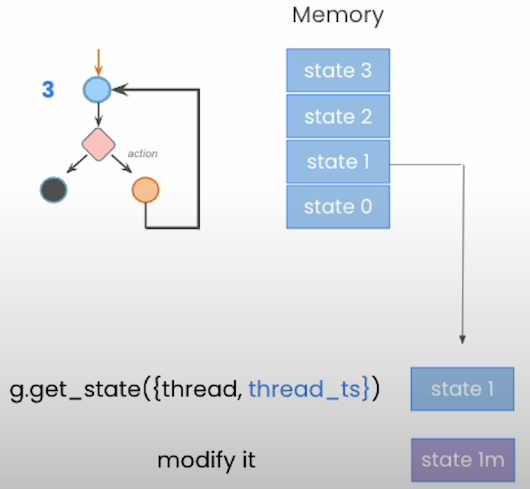

Then, you can use `update_state` to **update the state and store it back into memory in the location of the current state**.

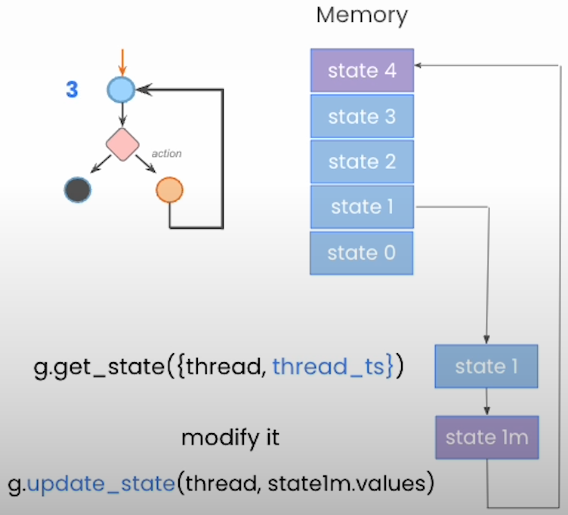

Finally, you can **run it** with `g.stream(None, thread)`

# Modify State

Run until the interrupt, then modify the state.

In [18]:
messages = [HumanMessage("What's the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        rprint(v)

{'messages': [HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174})]}


{
    'messages': [
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                        'function': {
                            'arguments': '{"query":"weather in Los Angeles"}',
                            'name': 'tavily_search_results_json'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                'model_name': 'gpt-3.5-turbo',
                'system_fingerprint': None,
                'finish_reason': 'tool_calls',
                'logprobs': None
            },
            id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
            tool_calls=[
                {
                    'name': 'tavily_search_results_json',
                    'args': {'query': 'weather in Los Angeles'},
                    'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                }
            ],
            usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
        )
    ]
}

In [19]:
rprint(abot.graph.get_state(thread))

StateSnapshot(
    values={
        'messages': [
            HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                            'function': {
                                'arguments': '{"query":"weather in Los Angeles"}',
                                'name': 'tavily_search_results_json'
                            },
                            'type': 'function'
                        }
                    ]
                },
                response_metadata={
                    'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                    'model_name': 'gpt-3.5-turbo',
                    'system_fingerprint': None,
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
                tool_calls=[
                    {
                        'name': 'tavily_search_results_json',
                        'args': {'query': 'weather in Los Angeles'},
                        'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                    }
                ],
                usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
            )
        ]
    },
    next=('action',),
    config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-f3b4-6709-8001-e681e69a42d3'}},
    metadata={
        'source': 'loop',
        'step': 1,
        'writes': {
            'llm': {
                'messages': [
                    AIMessage(
                        content='',
                        additional_kwargs={
                            'tool_calls': [
                                {
                                    'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                                    'function': {
                                        'arguments': '{"query":"weather in Los Angeles"}',
                                        'name': 'tavily_search_results_json'
                                    },
                                    'type': 'function'
                                }
                            ]
                        },
                        response_metadata={
                            'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                            'model_name': 'gpt-3.5-turbo',
                            'system_fingerprint': None,
                            'finish_reason': 'tool_calls',
                            'logprobs': None
                        },
                        id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
                        tool_calls=[
                            {
                                'name': 'tavily_search_results_json',
                                'args': {'query': 'weather in Los Angeles'},
                                'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                            }
                        ],
                        usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
                    )
                ]
            }
        }
    },
    created_at='2024-06-12T11:28:47.483423+00:00',
    parent_config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-e861-625a-8000-f426d23e9e24'}}
)

In [20]:
current_values = abot.graph.get_state(thread)

In [21]:
type(current_values)

langgraph.pregel.types.StateSnapshot

In [22]:
rprint(current_values.values)

{
    'messages': [
        HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                        'function': {
                            'arguments': '{"query":"weather in Los Angeles"}',
                            'name': 'tavily_search_results_json'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                'model_name': 'gpt-3.5-turbo',
                'system_fingerprint': None,
                'finish_reason': 'tool_calls',
                'logprobs': None
            },
            id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
            tool_calls=[
                {
                    'name': 'tavily_search_results_json',
                    'args': {'query': 'weather in Los Angeles'},
                    'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                }
            ],
            usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
        )
    ]
}

In [23]:
rprint(current_values.values["messages"][-1])

AIMessage(
    content='',
    additional_kwargs={
        'tool_calls': [
            {
                'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                'function': {
                    'arguments': '{"query":"weather in Los Angeles"}',
                    'name': 'tavily_search_results_json'
                },
                'type': 'function'
            }
        ]
    },
    response_metadata={
        'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
        'model_name': 'gpt-3.5-turbo',
        'system_fingerprint': None,
        'finish_reason': 'tool_calls',
        'logprobs': None
    },
    id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
    tool_calls=[
        {
            'name': 'tavily_search_results_json',
            'args': {'query': 'weather in Los Angeles'},
            'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
        }
    ],
    usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
)

In [24]:
rprint(current_values.values["messages"][-1].tool_calls)

[
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'weather in Los Angeles'},
        'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
    }
]

In [25]:
_id = current_values.values["messages"][-1].tool_calls[0]["id"]

current_values.values["messages"][-1].tool_calls = [
    {
        "name": "tavily_search_results_json",
        "args": {"query": "current weather in Louisiana"},
        "id": _id
    }
]

In [26]:
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174})]}


{'configurable': {'thread_id': '3',
  'thread_ts': '1ef28aee-f56e-62d9-8002-b1b55825993f'}}

In [27]:
rprint(abot.graph.get_state(thread))

StateSnapshot(
    values={
        'messages': [
            HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                            'function': {
                                'arguments': '{"query":"weather in Los Angeles"}',
                                'name': 'tavily_search_results_json'
                            },
                            'type': 'function'
                        }
                    ]
                },
                response_metadata={
                    'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                    'model_name': 'gpt-3.5-turbo',
                    'system_fingerprint': None,
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
                tool_calls=[
                    {
                        'name': 'tavily_search_results_json',
                        'args': {'query': 'current weather in Louisiana'},
                        'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                    }
                ],
                usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
            )
        ]
    },
    next=('action',),
    config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-f56e-62d9-8002-b1b55825993f'}},
    metadata={
        'source': 'update',
        'step': 2,
        'writes': {
            'llm': {
                'messages': [
                    HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'),
                    AIMessage(
                        content='',
                        additional_kwargs={
                            'tool_calls': [
                                {
                                    'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                                    'function': {
                                        'arguments': '{"query":"weather in Los Angeles"}',
                                        'name': 'tavily_search_results_json'
                                    },
                                    'type': 'function'
                                }
                            ]
                        },
                        response_metadata={
                            'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                            'model_name': 'gpt-3.5-turbo',
                            'system_fingerprint': None,
                            'finish_reason': 'tool_calls',
                            'logprobs': None
                        },
                        id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
                        tool_calls=[
                            {
                                'name': 'tavily_search_results_json',
                                'args': {'query': 'current weather in Louisiana'},
                                'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                            }
                        ],
                        usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
                    )
                ]
            }
        }
    },
    created_at='2024-06-12T11:28:47.664377+00:00',
    parent_config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-f3b4-6709-8001-e681e69a42d3'}}
)

In [28]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        rprint(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'}
Back to the model!


{
    'messages': [
        ToolMessage(
            content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': 
\'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.44, \'lon\': 
-91.06, \'tz_id\': \'America/Chicago\', \'localtime_epoch\': 1718191686, \'localtime\': \'2024-06-12 6:28\'}, 
\'current\': {\'last_updated_epoch\': 1718190900, \'last_updated\': \'2024-06-12 06:15\', \'temp_c\': 17.8, 
\'temp_f\': 64.0, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': 
\'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 4.3, \'wind_kph\': 6.8, 
\'wind_degree\': 190, \'wind_dir\': \'S\', \'pressure_mb\': 1016.0, \'pressure_in\': 29.99, \'precip_mm\': 0.0, 
\'precip_in\': 0.0, \'humidity\': 90, \'cloud\': 0, \'feelslike_c\': 17.8, \'feelslike_f\': 64.0, \'windchill_c\': 
17.6, \'windchill_f\': 63.7, \'heatindex_c\': 17.6, \'heatindex_f\': 63.7, \'dewpoint_c\': 15.4, \'dewpoint_f\': 
59.8, \'vis_km\': 16.0, \'vis_miles\': 9.0, \'uv\': 5.0, \'gust_mph\': 9.9, \'gust_kph\': 15.9}}"}, {\'url\': 
\'https://www.weather25.com/north-america/usa/louisiana?page=month&month=December\', \'content\': "Louisiana 
weather in December 2024. The temperatures in Louisiana in December are usually low and can range between 53°F and 
64°F. You can expect about 3 to 8 days of rain in Louisiana during the month of December. It\'s a good idea to 
bring along your umbrella so that you don\'t get caught in poor weather."}]',
            name='tavily_search_results_json',
            tool_call_id='call_xyyeZwOFqkEXAee8KhJF7PXJ'
        )
    ]
}

{'messages': [HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}), ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of Am

{
    'messages': [
        AIMessage(
            content='The current weather in Louisiana is as follows:\n- Temperature: 64.0°F (17.8°C)\n- Condition: 
Sunny\n- Wind: 4.3 mph (6.8 kph) from the south\n- Humidity: 90%\n- Visibility: 9.0 miles (16.0 km)\n- UV Index: 
5.0\n- Pressure: 29.99 in\n\nIs there anything else you would like to know?',
            response_metadata={
                'token_usage': {'completion_tokens': 97, 'prompt_tokens': 696, 'total_tokens': 793},
                'model_name': 'gpt-3.5-turbo',
                'system_fingerprint': None,
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-2de6a7e3-328a-4418-bf10-bb9fbeff32b7-0',
            usage_metadata={'input_tokens': 696, 'output_tokens': 97, 'total_tokens': 793}
        )
    ]
}

# Time Travel

In [29]:
states = []

for state in abot.graph.get_state_history(thread):
    rprint(state)
    print('-' * 50)
    states.append(state)

StateSnapshot(
    values={
        'messages': [
            HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                            'function': {
                                'arguments': '{"query":"weather in Los Angeles"}',
                                'name': 'tavily_search_results_json'
                            },
                            'type': 'function'
                        }
                    ]
                },
                response_metadata={
                    'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                    'model_name': 'gpt-3.5-turbo',
                    'system_fingerprint': None,
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
                tool_calls=[
                    {
                        'name': 'tavily_search_results_json',
                        'args': {'query': 'current weather in Louisiana'},
                        'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                    }
                ],
                usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
            ),
            ToolMessage(
                content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': 
\'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.44, \'lon\': 
-91.06, \'tz_id\': \'America/Chicago\', \'localtime_epoch\': 1718191686, \'localtime\': \'2024-06-12 6:28\'}, 
\'current\': {\'last_updated_epoch\': 1718190900, \'last_updated\': \'2024-06-12 06:15\', \'temp_c\': 17.8, 
\'temp_f\': 64.0, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': 
\'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 4.3, \'wind_kph\': 6.8, 
\'wind_degree\': 190, \'wind_dir\': \'S\', \'pressure_mb\': 1016.0, \'pressure_in\': 29.99, \'precip_mm\': 0.0, 
\'precip_in\': 0.0, \'humidity\': 90, \'cloud\': 0, \'feelslike_c\': 17.8, \'feelslike_f\': 64.0, \'windchill_c\': 
17.6, \'windchill_f\': 63.7, \'heatindex_c\': 17.6, \'heatindex_f\': 63.7, \'dewpoint_c\': 15.4, \'dewpoint_f\': 
59.8, \'vis_km\': 16.0, \'vis_miles\': 9.0, \'uv\': 5.0, \'gust_mph\': 9.9, \'gust_kph\': 15.9}}"}, {\'url\': 
\'https://www.weather25.com/north-america/usa/louisiana?page=month&month=December\', \'content\': "Louisiana 
weather in December 2024. The temperatures in Louisiana in December are usually low and can range between 53°F and 
64°F. You can expect about 3 to 8 days of rain in Louisiana during the month of December. It\'s a good idea to 
bring along your umbrella so that you don\'t get caught in poor weather."}]',
                name='tavily_search_results_json',
                id='c43b99fa-b929-483b-a4c5-0bd6719e75a8',
                tool_call_id='call_xyyeZwOFqkEXAee8KhJF7PXJ'
            ),
            AIMessage(
                content='The current weather in Louisiana is as follows:\n- Temperature: 64.0°F (17.8°C)\n- 
Condition: Sunny\n- Wind: 4.3 mph (6.8 kph) from the south\n- Humidity: 90%\n- Visibility: 9.0 miles (16.0 km)\n- 
UV Index: 5.0\n- Pressure: 29.99 in\n\nIs there anything else you would like to know?',
                response_metadata={
                    'token_usage': {'completion_tokens': 97, 'prompt_tokens': 696, 'total_tokens': 793},
                    'model_name': 'gpt-3.5-turbo',
                    'system_fingerprint': None,
                    'finish_reason': 'stop',
                    'logprobs': None
                },
                id='run-2de6a7e3-328a-4418-bf10-bb9fbeff32b7-0',
                usage

--------------------------------------------------


StateSnapshot(
    values={
        'messages': [
            HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                            'function': {
                                'arguments': '{"query":"weather in Los Angeles"}',
                                'name': 'tavily_search_results_json'
                            },
                            'type': 'function'
                        }
                    ]
                },
                response_metadata={
                    'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                    'model_name': 'gpt-3.5-turbo',
                    'system_fingerprint': None,
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
                tool_calls=[
                    {
                        'name': 'tavily_search_results_json',
                        'args': {'query': 'current weather in Louisiana'},
                        'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                    }
                ],
                usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
            ),
            ToolMessage(
                content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': 
\'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.44, \'lon\': 
-91.06, \'tz_id\': \'America/Chicago\', \'localtime_epoch\': 1718191686, \'localtime\': \'2024-06-12 6:28\'}, 
\'current\': {\'last_updated_epoch\': 1718190900, \'last_updated\': \'2024-06-12 06:15\', \'temp_c\': 17.8, 
\'temp_f\': 64.0, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': 
\'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 4.3, \'wind_kph\': 6.8, 
\'wind_degree\': 190, \'wind_dir\': \'S\', \'pressure_mb\': 1016.0, \'pressure_in\': 29.99, \'precip_mm\': 0.0, 
\'precip_in\': 0.0, \'humidity\': 90, \'cloud\': 0, \'feelslike_c\': 17.8, \'feelslike_f\': 64.0, \'windchill_c\': 
17.6, \'windchill_f\': 63.7, \'heatindex_c\': 17.6, \'heatindex_f\': 63.7, \'dewpoint_c\': 15.4, \'dewpoint_f\': 
59.8, \'vis_km\': 16.0, \'vis_miles\': 9.0, \'uv\': 5.0, \'gust_mph\': 9.9, \'gust_kph\': 15.9}}"}, {\'url\': 
\'https://www.weather25.com/north-america/usa/louisiana?page=month&month=December\', \'content\': "Louisiana 
weather in December 2024. The temperatures in Louisiana in December are usually low and can range between 53°F and 
64°F. You can expect about 3 to 8 days of rain in Louisiana during the month of December. It\'s a good idea to 
bring along your umbrella so that you don\'t get caught in poor weather."}]',
                name='tavily_search_results_json',
                id='c43b99fa-b929-483b-a4c5-0bd6719e75a8',
                tool_call_id='call_xyyeZwOFqkEXAee8KhJF7PXJ'
            )
        ]
    },
    next=('llm',),
    config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aef-0f05-60cb-8003-3ac279351629'}},
    metadata={
        'source': 'loop',
        'step': 3,
        'writes': {
            'action': {
                'messages': [
                    ToolMessage(
                        content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': 
{\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.44, 
\'lon\': -91.06, \'tz_id\': \'America/Chicago\', \'localtime_epoch\': 1718191686, \'localtime\': \'2024-06-12 
6:28\'}, \'current\': {\'last_updated_epoch\': 1718190900, \'last_updated\': \'2024-06-12 06:15\', \'temp_c\': 
17.8, \'temp

--------------------------------------------------


StateSnapshot(
    values={
        'messages': [
            HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                            'function': {
                                'arguments': '{"query":"weather in Los Angeles"}',
                                'name': 'tavily_search_results_json'
                            },
                            'type': 'function'
                        }
                    ]
                },
                response_metadata={
                    'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                    'model_name': 'gpt-3.5-turbo',
                    'system_fingerprint': None,
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
                tool_calls=[
                    {
                        'name': 'tavily_search_results_json',
                        'args': {'query': 'current weather in Louisiana'},
                        'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                    }
                ],
                usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
            )
        ]
    },
    next=('action',),
    config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-f56e-62d9-8002-b1b55825993f'}},
    metadata={
        'source': 'update',
        'step': 2,
        'writes': {
            'llm': {
                'messages': [
                    HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'),
                    AIMessage(
                        content='',
                        additional_kwargs={
                            'tool_calls': [
                                {
                                    'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                                    'function': {
                                        'arguments': '{"query":"weather in Los Angeles"}',
                                        'name': 'tavily_search_results_json'
                                    },
                                    'type': 'function'
                                }
                            ]
                        },
                        response_metadata={
                            'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                            'model_name': 'gpt-3.5-turbo',
                            'system_fingerprint': None,
                            'finish_reason': 'tool_calls',
                            'logprobs': None
                        },
                        id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
                        tool_calls=[
                            {
                                'name': 'tavily_search_results_json',
                                'args': {'query': 'current weather in Louisiana'},
                                'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                            }
                        ],
                        usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
                    )
                ]
            }
        }
    },
    created_at='2024-06-12T11:28:47.664377+00:00',
    parent_config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-f3b4-6709-8001-e681e69a42d3'}}
)

--------------------------------------------------


StateSnapshot(
    values={
        'messages': [
            HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                            'function': {
                                'arguments': '{"query":"weather in Los Angeles"}',
                                'name': 'tavily_search_results_json'
                            },
                            'type': 'function'
                        }
                    ]
                },
                response_metadata={
                    'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                    'model_name': 'gpt-3.5-turbo',
                    'system_fingerprint': None,
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
                tool_calls=[
                    {
                        'name': 'tavily_search_results_json',
                        'args': {'query': 'weather in Los Angeles'},
                        'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                    }
                ],
                usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
            )
        ]
    },
    next=('action',),
    config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-f3b4-6709-8001-e681e69a42d3'}},
    metadata={
        'source': 'loop',
        'step': 1,
        'writes': {
            'llm': {
                'messages': [
                    AIMessage(
                        content='',
                        additional_kwargs={
                            'tool_calls': [
                                {
                                    'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ',
                                    'function': {
                                        'arguments': '{"query":"weather in Los Angeles"}',
                                        'name': 'tavily_search_results_json'
                                    },
                                    'type': 'function'
                                }
                            ]
                        },
                        response_metadata={
                            'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174},
                            'model_name': 'gpt-3.5-turbo',
                            'system_fingerprint': None,
                            'finish_reason': 'tool_calls',
                            'logprobs': None
                        },
                        id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0',
                        tool_calls=[
                            {
                                'name': 'tavily_search_results_json',
                                'args': {'query': 'weather in Los Angeles'},
                                'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'
                            }
                        ],
                        usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}
                    )
                ]
            }
        }
    },
    created_at='2024-06-12T11:28:47.483423+00:00',
    parent_config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-e861-625a-8000-f426d23e9e24'}}
)

--------------------------------------------------


StateSnapshot(
    values={
        'messages': [
            HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92')
        ]
    },
    next=('llm',),
    config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-e861-625a-8000-f426d23e9e24'}},
    metadata={'source': 'loop', 'step': 0, 'writes': None},
    created_at='2024-06-12T11:28:46.295887+00:00',
    parent_config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-e857-61e2-bfff-a4c7371cb482'}}
)

--------------------------------------------------


StateSnapshot(
    values={'messages': []},
    next=('__start__',),
    config={'configurable': {'thread_id': '3', 'thread_ts': '1ef28aee-e857-61e2-bfff-a4c7371cb482'}},
    metadata={
        'source': 'input',
        'step': -1,
        'writes': {'messages': [HumanMessage(content="What's the weather in LA?")]}
    },
    created_at='2024-06-12T11:28:46.291767+00:00',
    parent_config=None
)

--------------------------------------------------


In [30]:
states

[StateSnapshot(values={'messages': [HumanMessage(content="What's the weather in LA?", id='9f55d840-0236-42e6-aa86-c95330693f92'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c067eca9-02c6-440e-8253-533f83fab6c4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_xyyeZwOFqkEXAee8KhJF7PXJ'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}), ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'U